In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_14.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_65.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_87.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_96.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_72.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_50.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_1.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_100.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_81.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_54.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_13.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_89.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_83.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_31.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla_60.jpg
/kaggle/input/tree-10/Tree_classification/Amla(55)/Amla

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from shutil import copyfile

def augment_image(image_path, output_dir):
    img = cv2.imread(image_path)
    if img is None:
        return  # Skip corrupted files
    h, w = img.shape[:2]
    filename = os.path.splitext(os.path.basename(image_path))[0]
    
    # Save original
    cv2.imwrite(os.path.join(output_dir, f"{filename}.jpg"), img)
    
    # Standard rotations (90°, 180°, 270°)
    for angle in [90, 180, 270]:
        rotated = np.rot90(img, k=angle // 90)
        cv2.imwrite(os.path.join(output_dir, f"{filename}_rot{angle}.jpg"), rotated)
    
    # Tilted rotations (30°, 45°)
    for angle in [30, 45]:
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
        cv2.imwrite(os.path.join(output_dir, f"{filename}_tilt{angle}.jpg"), rotated)
    
    # Horizontal flip
    flipped = cv2.flip(img, 1)
    cv2.imwrite(os.path.join(output_dir, f"{filename}_flip.jpg"), flipped)

# Step 1: Augment all images
base_dir = "/kaggle/input/tree-10/Tree_classification"
augmented_dir = "Tree_classification_augmented"
os.makedirs(augmented_dir, exist_ok=True)

for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    augmented_class_dir = os.path.join(augmented_dir, class_name)
    os.makedirs(augmented_class_dir, exist_ok=True)
    
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        augment_image(img_path, augmented_class_dir)

# Step 2: Split into train/val/test (70/20/10)
for class_name in os.listdir(augmented_dir):
    class_dir = os.path.join(augmented_dir, class_name)
    if not os.path.isdir(class_dir):
        continue  # Skip non-directory files
    
    images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))]
    if not images:
        continue  # Skip empty folders
    
    # Split 70% train, 20% val, 10% test
    train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.333, random_state=42)
    
    # Create split directories and copy files
    for split, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
        split_dir = os.path.join(augmented_dir, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for f in files:
            src = os.path.join(class_dir, f)
            dst = os.path.join(split_dir, f)
            copyfile(src, dst)

print("Augmentation and splitting complete!")

Augmentation and splitting complete!


In [3]:
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Only contrast enhancement (no resizing)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    
    return img_clahe  # Still 256x256

def extract_features(img):
    if img is None:
        return None
    
    # Color Histogram (RGB)
    hist_r = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
    
    # Texture (Haralick via GLCM)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    
    # Combine features
    features = np.concatenate([hist_r, hist_g, hist_b, [contrast, energy]])
    return features

In [4]:
def load_data(root_dir):
    X, y = [], []
    class_names = sorted(os.listdir(root_dir))
    label_map = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_dir = os.path.join(root_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = preprocess_image(img_path)
            if img is not None:
                features = extract_features(img)
                X.append(features)
                y.append(label_map[class_name])
    
    return np.array(X), np.array(y), label_map

X_train, y_train, label_map = load_data("/kaggle/working/Tree_classification_augmented/train")
X_val, y_val, _ = load_data("/kaggle/working/Tree_classification_augmented/val")

In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Validate
y_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=label_map.keys()))

Validation Accuracy: 0.94750656167979
                       precision    recall  f1-score   support

Acacia Polycantha(58)       0.90      0.90      0.90        81
        Akashneem(56)       0.99      0.92      0.95        77
             Amba(59)       0.95      0.98      0.96        82
             Amla(55)       0.89      0.95      0.92        77
            Anant(53)       0.97      0.97      0.97        74
            Anjir(53)       0.96      1.00      0.98        74
             Apta(55)       0.97      0.92      0.95        77
            Arjun(48)       1.00      0.88      0.94        67
         Ashoka (D)48       1.00      0.99      0.99        67
           Ashoka(68)       0.88      0.97      0.92        86

             accuracy                           0.95       762
            macro avg       0.95      0.95      0.95       762
         weighted avg       0.95      0.95      0.95       762



In [6]:
X_test, y_test, _ = load_data("Tree_classification_augmented/test")
y_pred_test = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

Test Accuracy: 0.9560723514211886


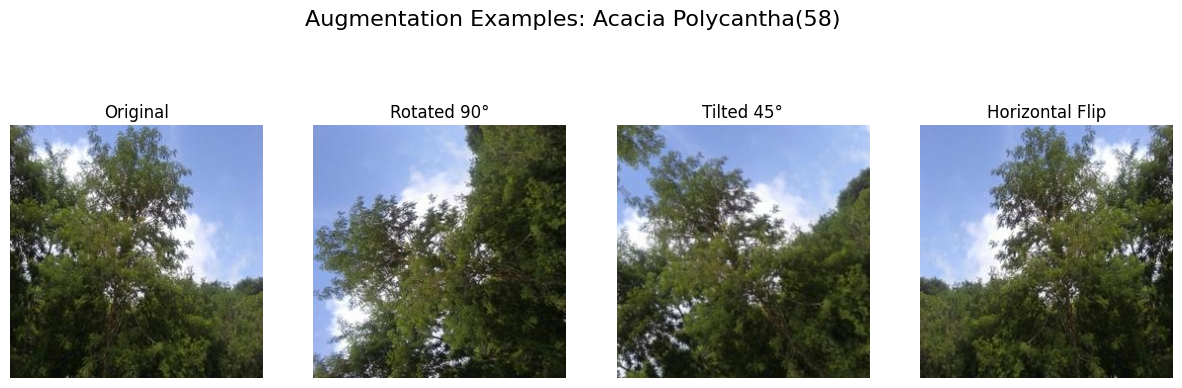

In [7]:
import matplotlib.pyplot as plt
import cv2
import os

def plot_augmented_samples(class_name="Acacia_Polycantha", sample_img="tree1.jpg"):
    base_dir = "Tree_classification_augmented"
    img_dir = os.path.join(base_dir, class_name)
    
    # Load original and augmented images
    original = cv2.imread(os.path.join(img_dir, f"{sample_img}"))
    rot90 = cv2.imread(os.path.join(img_dir, f"{sample_img.split('.')[0]}_rot90.jpg"))
    tilt45 = cv2.imread(os.path.join(img_dir, f"{sample_img.split('.')[0]}_tilt45.jpg"))
    flip = cv2.imread(os.path.join(img_dir, f"{sample_img.split('.')[0]}_flip.jpg"))
    
    # Convert BGR to RGB for matplotlib
    images = {
        "Original": cv2.cvtColor(original, cv2.COLOR_BGR2RGB),
        "Rotated 90°": cv2.cvtColor(rot90, cv2.COLOR_BGR2RGB),
        "Tilted 45°": cv2.cvtColor(tilt45, cv2.COLOR_BGR2RGB),
        "Horizontal Flip": cv2.cvtColor(flip, cv2.COLOR_BGR2RGB)
    }
    
    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for (title, img), ax in zip(images.items(), axes):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f"Augmentation Examples: {class_name}", fontsize=16)
    plt.show()

# Example usage
plot_augmented_samples(class_name="Acacia Polycantha(58)", sample_img="Acacia Polycantha_10.jpg")

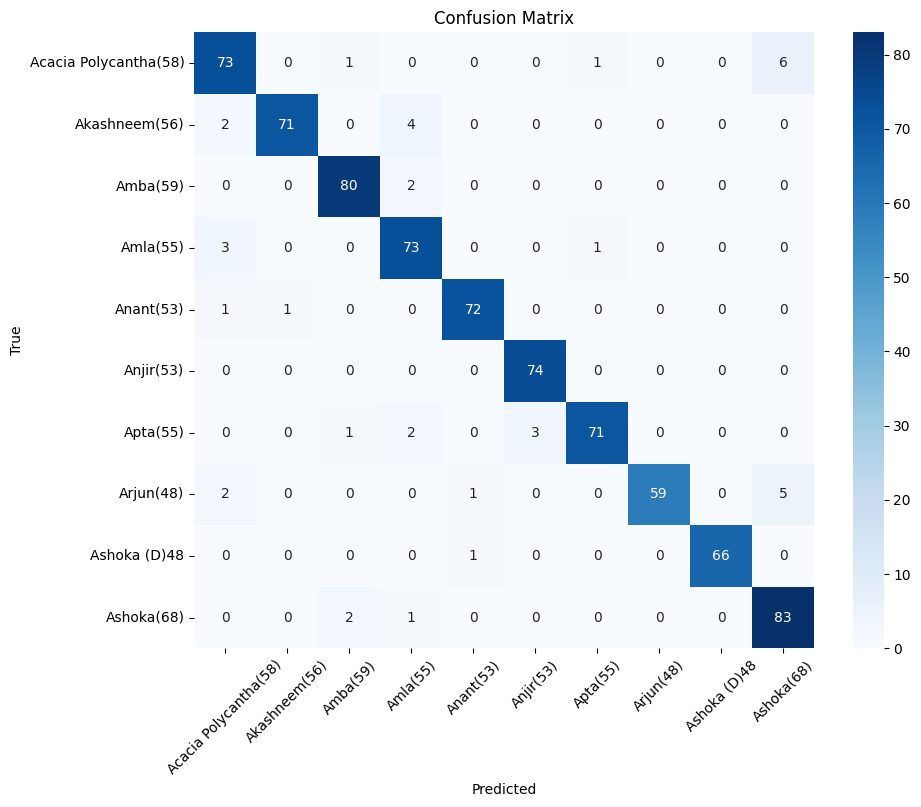

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Example usage (after model training)
class_names = list(label_map.keys())
y_pred_val = clf.predict(X_val)
plot_confusion_matrix(y_val, y_pred_val, class_names)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_val, target_names=class_names))

                       precision    recall  f1-score   support

Acacia Polycantha(58)       0.90      0.90      0.90        81
        Akashneem(56)       0.99      0.92      0.95        77
             Amba(59)       0.95      0.98      0.96        82
             Amla(55)       0.89      0.95      0.92        77
            Anant(53)       0.97      0.97      0.97        74
            Anjir(53)       0.96      1.00      0.98        74
             Apta(55)       0.97      0.92      0.95        77
            Arjun(48)       1.00      0.88      0.94        67
         Ashoka (D)48       1.00      0.99      0.99        67
           Ashoka(68)       0.88      0.97      0.92        86

             accuracy                           0.95       762
            macro avg       0.95      0.95      0.95       762
         weighted avg       0.95      0.95      0.95       762



In [10]:
import joblib

# Assume you've already trained `clf` and have `label_map`
joblib.dump(clf, 'random_forest_model.joblib')  # Save the model
joblib.dump(label_map, 'label_map.joblib')      # Save the class-label mapping

# Verify files are saved
!ls -l  # Check if files appear in Kaggle's output

total 13288
-rw-r--r--  1 root root      173 Apr 25 10:36 label_map.joblib
----------  1 root root   834692 Apr 25 10:36 __notebook__.ipynb
-rw-r--r--  1 root root 12762537 Apr 25 10:36 random_forest_model.joblib
drwxr-xr-x 15 root root     4096 Apr 25 10:36 Tree_classification_augmented


In [11]:
# Load the saved model and label map
model = joblib.load('/kaggle/working/random_forest_model.joblib')  # or .pkl
label_map = joblib.load('/kaggle/working/label_map.joblib')   

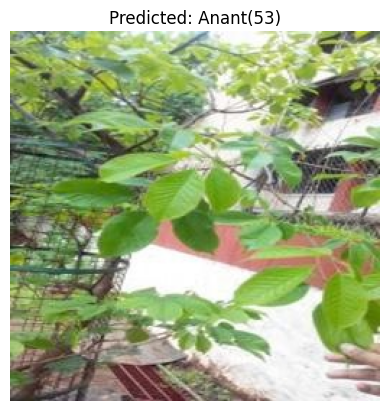

Predicted Class: Anant(53)


In [12]:
def predict_and_show(image_path):
    try:
        # Preprocess + predict
        img_processed = preprocess_image(image_path)
        features = extract_features(img_processed).reshape(1, -1)
        pred_label = model.predict(features)[0]
        pred_class = list(label_map.keys())[list(label_map.values()).index(pred_label)]
        
        # Display
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class}")
        plt.axis('off')
        plt.show()
        return pred_class
    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage
input_image = '/kaggle/working/Tree_classification_augmented/Anant(53)/Anant_14_flip.jpg'  # Replace with your image path
predicted_class = predict_and_show(input_image)
print(f"Predicted Class: {predicted_class}")